In [1]:
%matplotlib inline

import numpy as np
from clawpack import riemann
from clawpack import pyclaw

        
def qtrue(x,t):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and
    beta = 100
    gamma = 0
    x0 = 0.75
    if isinstance(x,(np.ndarray,list)):
        m = np.size(x)
        q = np.empty((m))
        for i in range(m):
            xm = (np.sqrt(x[i])-t)**2
            if x[i] != 0.:
                q[i] = qinit(xm)/np.sqrt(x[i])*np.sqrt(xm)
            else:
                q[i] = 0.
    if isinstance(x,(float,int)):
        if x != 0:
            xm = (np.sqrt(x)-t)**2
            q = qinit(xm)/np.sqrt(x)*np.sqrt(xm)
        else:
            q = 0
    return q
        
def qinit(x):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and
    beta = 100
    gamma = 0
    x0 = 0.75
    q = exp(-beta * (x-x0)**2) + where(logical_and(x > 0.1, x < 0.4),  1, 0)
    return q

def SpatialAdvection2(q_l,q_r,aux_l,aux_r,problem_data):
    r"""Basic 1d advection riemann solver   
    *aux(i)* should contain -
     - *u(x_i)* - (float) advection speed
    """
    num_eqn = 1
    num_waves = 1
    # Number of Riemann problems we are solving
    num_rp = q_l.shape[1]
 
    # Return values
    wave = np.zeros( (num_eqn,num_waves,num_rp) )
    s    = np.zeros( (num_waves,num_rp) )
    amdq = np.zeros( (num_eqn,num_rp) )
    apdq = np.zeros( (num_eqn,num_rp) )
    q_sp = np.zeros( (num_eqn,num_rp) )
    q_sm = np.zeros( (num_eqn,num_rp) )
    eps = 1.e-12
    for i in range(num_rp):
        u = aux_r[0,i]  
        p = aux_l[0,i]
        q_sp[0,i] = p*q_l[0,i]/u 
        q_sm[0,i] = u*q_r[0,i]/p
        wave[0,0,i] = (p>0)*(q_r[0,i]-q_sp[0,i])+(p<0)*(q_sm[0,i]-q_l[0,i])
        s[0,i] =  (p>0)*u+(p<0)*p
        apdq[0,i] = s[0,i] * wave[0,0,i]*(p>0) 
        amdq[0,i] = s[0,i] * wave[0,0,i]*(p<0)
            

    return wave, s, amdq, apdq

def SpatialAdvection(q_l,q_r,aux_l,aux_r,problem_data):
    r"""Basic 1d advection riemann solver   
    *aux(i)* should contain -
     - *u(x_i)* - (float) advection speed
    """
    num_eqn = 1
    num_waves = 1
    # Number of Riemann problems we are solving
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn,num_waves,num_rp) )
    s = np.empty( (num_waves,num_rp) )
    amdq = np.zeros( (num_eqn,num_rp) )
    apdq = np.zeros( (num_eqn,num_rp) )
    q_sp = np.zeros( (num_eqn,num_rp) )
    q_sm = np.zeros( (num_eqn,num_rp) )
    eps = 1.e-12
     
    q_sp[0,:] = q_l[0,:]*aux_l[0,:]/ (aux_r[0,:]+eps)
    q_sm[0,:] = q_r[0,:]*aux_r[0,:]/ (aux_l[0,:]+eps)
    wave[0,0,:] = (aux_l[0,:]<0)*(q_sm[0,:] - q_l[0,:])+(aux_l[0,:]>0)*(q_r[0,:] - q_sp[0,:])

    s[0,:] = (aux_l[0,:]>0)* aux_r[0,:] +(aux_l[0,:]<0)* aux_l[0,:] 

    apdq[0,:] =  (aux_l[0,:]>0)*s[0,:] * wave[0,0,:]
    amdq[0,:] =  (aux_l[0,:]<0)*s[0,:] * wave[0,0,:]

    return wave, s, amdq, apdq

# Advection speed
def auxinit(state):
    # Initialize petsc Structures for aux
    xc = state.grid.x.centers
    state.aux[0,:] =  2*np.sqrt(xc)
    
 
    

def setup(typeSolver=1,outdir='./_output'):
    from clawpack import riemann

    if typeSolver == 2:
        solver = pyclaw.ClawSolver1D(SpatialAdvection2)
        solver.kernel_language = 'Python'
    elif typeSolver == 1:
        solver = pyclaw.ClawSolver1D(advectionVariableBis)
        solver.kernel_language = 'Fortran'
    solver.num_waves = 1
    solver.num_eqn = 1
    solver.limiters = pyclaw.limiters.tvd.superbee
    solver.order = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    
    solver.limiters = pyclaw.limiters.tvd.MC
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap

    xlower = 0.00; xupper = 2.0; mx = 200
    x      = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_aux, num_eqn = 1, 1
    state  = pyclaw.State(domain,num_eqn,num_aux)

    xc = domain.grid.x.centers
    state.q[0,:] = qinit(xc)
    auxinit(state)

    claw = pyclaw.Controller()
    claw.outdir = outdir
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver

    claw.tfinal = 1
    claw.num_output_times = 20
    claw.keep_copy = True
    
    return claw


2024-04-01 15:07:55,225 INFO CLAW: Solution 0 computed for time t=0.000000


2024-04-01 15:07:55,266 INFO CLAW: Solution 1 computed for time t=0.050000
2024-04-01 15:07:55,308 INFO CLAW: Solution 2 computed for time t=0.100000
2024-04-01 15:07:55,348 INFO CLAW: Solution 3 computed for time t=0.150000
2024-04-01 15:07:55,389 INFO CLAW: Solution 4 computed for time t=0.200000
2024-04-01 15:07:55,425 INFO CLAW: Solution 5 computed for time t=0.250000
2024-04-01 15:07:55,465 INFO CLAW: Solution 6 computed for time t=0.300000
2024-04-01 15:07:55,501 INFO CLAW: Solution 7 computed for time t=0.350000
2024-04-01 15:07:55,536 INFO CLAW: Solution 8 computed for time t=0.400000
2024-04-01 15:07:55,570 INFO CLAW: Solution 9 computed for time t=0.450000
2024-04-01 15:07:55,604 INFO CLAW: Solution 10 computed for time t=0.500000
2024-04-01 15:07:55,638 INFO CLAW: Solution 11 computed for time t=0.550000
2024-04-01 15:07:55,672 INFO CLAW: Solution 12 computed for time t=0.600000
2024-04-01 15:07:55,711 INFO CLAW: Solution 13 computed for time t=0.650000
2024-04-01 15:07:55,7

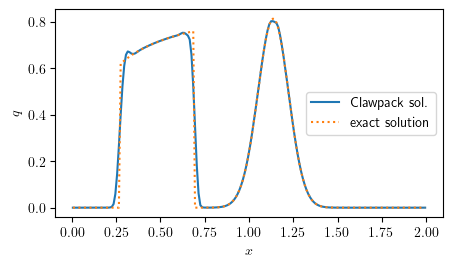

In [2]:

claw = setup(typeSolver=2)
claw.run()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
index = 4
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t = dt*index
x = frame.state.grid.c_centers
x = x[0]

 
true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, label='Clawpack sol.')
ax.plot(x, true, ':',label='exact solution')
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("SpatiallyVaryingAdvection.pdf",bbox_inches='tight')

In [3]:
def advection_animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method defined above:
    claw = setup(typeSolver=2)
    claw.keep_copy = True
    claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0.00, 2.0, 200)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 2))
    axes.set_title("Advection equation")
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-0.1,2.1))
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'ro')
        exact_line, = axes.plot(x_true, qtrue(x_true,0.0), 'b--')
        return (computed_line, exact_line)
    
    computed_line, exact_line = init()
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [qtrue(x_true,claw.frames[n].t)])
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=None, repeat=False)



In [4]:
from IPython.display import HTML 
anim = advection_animation()
HTML(anim.to_jshtml())

2024-04-01 15:08:14,952 INFO CLAW: Solution 0 computed for time t=0.000000
2024-04-01 15:08:14,995 INFO CLAW: Solution 1 computed for time t=0.050000
2024-04-01 15:08:15,049 INFO CLAW: Solution 2 computed for time t=0.100000
2024-04-01 15:08:15,098 INFO CLAW: Solution 3 computed for time t=0.150000
2024-04-01 15:08:15,142 INFO CLAW: Solution 4 computed for time t=0.200000
2024-04-01 15:08:15,182 INFO CLAW: Solution 5 computed for time t=0.250000
2024-04-01 15:08:15,219 INFO CLAW: Solution 6 computed for time t=0.300000
2024-04-01 15:08:15,255 INFO CLAW: Solution 7 computed for time t=0.350000
2024-04-01 15:08:15,289 INFO CLAW: Solution 8 computed for time t=0.400000
2024-04-01 15:08:15,324 INFO CLAW: Solution 9 computed for time t=0.450000
2024-04-01 15:08:15,359 INFO CLAW: Solution 10 computed for time t=0.500000
2024-04-01 15:08:15,392 INFO CLAW: Solution 11 computed for time t=0.550000
2024-04-01 15:08:15,426 INFO CLAW: Solution 12 computed for time t=0.600000
2024-04-01 15:08:15,46

In [5]:
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig, ax = plt.subplots(figsize=(5, 3))
      
    frame = claw.frames[i]
    w = frame.q[0,:]
    x = frame.state.grid.c_centers
    x = x[0]
    dt = claw.tfinal/claw.num_output_times
    t = dt*i
    true = qtrue(x,t)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$q$')
    plt.plot(x, w)
    plt.plot(x, true, '--',color = 'r')
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs) 


interactive(children=(IntSlider(value=0, description='frameno', max=20), Output()), _dom_classes=('widget-inte…

In [17]:
anim.save('ConvectiveAdvection.mp4',fps=5,writer='ffmpeg',dpi=300)

2024-01-10 20:09:13,575 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-01-10 20:09:13,576 INFO CLAW: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ConvectiveAdvection.mp4
